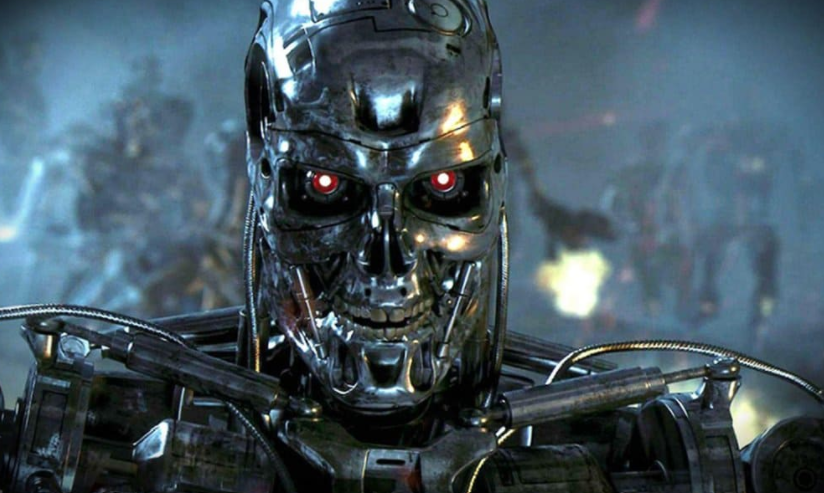

  <h3 align="center">Tradinator</h3>

  <p align="center">
    A sophisticated Machine Learning Algoritmic Trading Bot, sent back through time to help crypto humans successfully trade.
  </p>
</p>

## Overview

Tradinator is a free and open-source crypto trading bot written in Python. It is currently designed to support exchanges like Kraken and Coinspot and be controlled via AWS Lex and integrated into our Slack channel.

The tradinator gathers live data on a select number of cryptocurrencies and compares the data with results produced through Machine Learning models to predict the Buy and Sell signals.

Trades will then be automatically placed by the Tradintor using these recommendations on your Kraken exchange account every hour.

### Libraries

The tradinator uses a variety of ready-made python libraries. These libraries are:
* Pandas - Used to manipulate the price data into workable DataFrames
* CCXT - A crypto-specific library used to connect and trade with cryptocurrency exchanges.
* Finance - We used this library to download historical market data.
* Tensorflow - A library used to build and train Neural Network models.
* Keras - This API is built on top of Tensorflow.
* Scikit Learning - A library used to build and train Machine Learning models.
* Matplotlib - A python library used to render static, animated and interactive graphs.
* TA-Lib - This library performs technical analysis on our chosen cryptocurrencies.

### Technical Indicators

The Tradinator uses techinical analysis indicators to identify Buy or Sell signals. These signals are also backtested against historical data. Technical indicators are:

#### Momentum
* SMA - (Simple Moving Average)
* RSI - (Relative Strength Index)
* CCI - (Commodity Channel Index)
* MACD - (Moving Average Convergence Divergence)

#### Trend Strength
* ADX - (Average Directional Movment Index)

#### Volatility
* ATR - (Average True Range)
* BB - (Bolliner Bands)

#### Volume 
* SMA (Simple Moving Average- For Volume)

### Machine Learning Models

* Suport Vector
* Decision Tree
* Logical Regression
* Random Forrest
* Gradient Boost
* Adaptive Boosting
* LSTM RNN

Out of of all models the best results came from from Adaptive Boost. 

### Backtest Results
Strategy Performance on individual currency pairs

|![BTC-AUD](Data_ML_models_training/Backtest_results/Results_BTC-AUD.png) | ![ETH-AUD](Data_ML_models_training/Backtest_results/Results_ETH-AUD.png) | ![BCH-AUD](Data_ML_models_training/Backtest_results/Results_BCH-AUD.png)
|---|---|---
|![ADA-AUD](Data_ML_models_training/Backtest_results/Results_ADA-AUD.png) | ![XRP-AUD](Data_ML_models_training/Backtest_results/Results_XRP-AUD.png) | ![XLM-AUD](Data_ML_models_training/Backtest_results/Results_XLM-AUD.png)
|![LTC-AUD](Data_ML_models_training/Backtest_results/Results_LTC-AUD.png)||

### Predictions and Trading

* Uploaded the Joblib file to AWS S3 Bucket
* Created a script that runs in the first minute of every hour and does the follow:

* Get the Joblib file from S3 
* Asyncronsely creates tasks for each coin the Tradinator supports
* Generates predictions for the coin
* Executes the latest signal generated for the coin
* Saves the generated prediction to a .csv file and uploads that to the S3 bucket

### AWS Lex Bot

The Lex bot allows the user to interact with the Tradinator to get recommendation and place buy orders on the Kracken Exchance through a messaging platform called Slack. 

(Demo)

### Conclusions and Learnings

## Machine Learning Process

![Process Diagram](Data_ML_models_training/Images/ML_process.png)


# Index
---

## Data Fetch

> Jupyter Notebook - [yfinance_data_for_training.ipynb](Data_ML_models_training/yfinance_data_for_training.ipynb)
>
> Jupyter Notebook - [CCXT_data_for_testing.ipynb](Data_ML_models_training/CCXT_data_for_testing.ipynb)
---

## Clean, Prepare & Manipulate Data

> Functions for calculating and adding Technical Indicators - [CronJobs/Utility_Functions/Functions.py](Data_ML_models_training/CronJobs/Utility_Functions/Functions.py)
>
> Computing Target Values, Feature Selection and Pre-processing - [Feature_sel_and_ML_training.ipynb](Data_ML_models_training/Feature_sel_and_ML_training.ipynb)

# Step 1 - Get Data

### Training Data from yfinance. 

[Jupyter Notebook](Data_ML_models_training/yfinance_data_for_training.ipynb)

In [ ]:
# Import libraries and dependencies
import ccxt
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import talib as ta
import yfinance as yf 
import datetime as dt 

from CronJobs.Utility_Functions import Functions

In [ ]:
currs_list = [ 'BTC-AUD', 'ETH-AUD', 'XRP-AUD' , 'LTC-AUD', 'ADA-AUD', 'XLM-AUD', 'BCH-AUD']
start_date = '2019-06-01'
end_date = '2021-09-01'
interval = '1h'

df_data = yf.download(currs_list, start= start_date, end= end_date, interval= interval, group_by= 'ticker')

### Testing Data using CCXT with Kraken as Exchange

[Jupyter Notbook](Data_ML_models_training/CCXT_data_for_testing.ipynb)

In [ ]:
currs_list = ['ETH/AUD', 'XRP/AUD' , 'LTC/AUD', 'ADA/AUD', 'XLM/AUD', 'BCH/AUD']     #

dict_ohlcv = {}

for curr in currs_list:
    
    # Call data fetch
    ohlcv = exchange.fetchOHLCV(curr, '1h')

    # Store the values in a dataframe
    df_ohlcv = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']).set_index('Date')
    df_ohlcv.index = pd.to_datetime(df_ohlcv.index, unit='ms')

    df_ohlcv.dropna(inplace=True)

    # Store the symbol name and history data in a dict 
    dict_ohlcv[curr] = df_ohlcv 

    start_date = df_ohlcv.index[0].date().isoformat()
    end_date = df_ohlcv.index[-1].date().isoformat()
    num_records = (len(df_ohlcv))
    start_price = df_ohlcv.iloc[0]['Close']
    end_price = df_ohlcv.iloc[-1]['Close']

    print(f'Data summary for {curr}')
    print(f'    Start Date: {start_date}; End Date: {end_date}; NUmber of records: {num_records}')
    print(f'    Start Price: {start_price}; End Price: {end_price}')    
    print(f'Data for {curr} fetched and appended into the dictionary\n')

# Step 2 - Clean, Prepare, Manipulate Data and Feature Selection

In [ ]:
## Function for calculating and adding Technical Indicators

Function .py file - [CronJobs/Utility_Functions/Functions.py](Data_ML_models_training/CronJobs/Utility_Functions/Functions.py)

Library - TA-lib

Indicators Used:

- Momentum Indicators - SMA, RSI, CCI, MACD
- Trend Strength Indicators - ADX
- Volatility Indicators - ATR, Bollinger Bands
- Volume Indicators - SMA(Volume)

In [ ]:
def add_tech_indicators(df, fast, slow):
    
#---------------------------------------------------------------------
# Momentum Indicators
#---------------------------------------------------------------------
# SMA indicators fast and slow
    sma_fast = ta.SMA(df['Close'], timeperiod=fast )
    sma_slow = ta.SMA(df['Close'], timeperiod=slow )
    df['SMA_agg'] = sma_fast / sma_slow 

# RSI Ratio
    rsi_fast = ta.RSI(df['Close'], fast)
    rsi_slow = ta.RSI(df['Close'], slow)
    df['RSI_ratio'] = rsi_fast / rsi_slow

# CCI
    df['CCI'] = ta.CCI(df['High'], df['Low'], df['Close'], fast)

# MACD
# We'll be using MACD_ratio which is MACD / Signal. We will multiply it by -1 if MACD is lesser than 0. 
# So the MACD ratio will range from:
    # ratio < -1, when the MACD is below 0 and MACD is below Signal line 
    # -1 > ratio > 0, when the MACD is above Signal line but below 0
    # 0 < ratio < 1, when MACD is below signal but above 0 
    # 1 < ratio, when MACD is above 0 and above the signal line 
    df['MACD'], df['Signal'], hist = ta.MACD(df['Close'], fastperiod=fast, slowperiod=slow, signalperiod=8) 
    df['MACD_ratio'] =  df['MACD'] / df['Signal']
    df['MACD_ratio'] = df['MACD_ratio'] * df['MACD'] / abs(df['MACD'])          

    df.drop(columns= ['MACD', 'Signal'], inplace = True)

#---------------------------------------------------------------------
# Trend Strength Indicators
#---------------------------------------------------------------------
# ADX
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod= fast)
    df['plus_DI'] = ta.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod= fast)
    df['minus_DI'] = ta.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod= fast)
    df['ADX_dirn'] = np.where(df['plus_DI'] > df['minus_DI'], 1.0, 0.0)

    df.drop(columns=['plus_DI', 'minus_DI'], inplace=True)

#---------------------------------------------------------------------
# Volatility Indicators
#---------------------------------------------------------------------
# ATR Ratio: fast / slow. if value is less than 1, the price volatility is slowing
    atr_fast = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod= fast)
    atr_slow = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod= slow)
    df['ATR_ratio'] = atr_fast / atr_slow

# Bollinger Bands: periods = fast; Std.Dev = 1
    df['BBands_high'], middle, df['BBands_low']  = ta.BBANDS(df['Close'], timeperiod= fast, nbdevup= 1, nbdevdn= 1)

    df['BBands_high'] = df['BBands_high'] / df['Close']             # Value lesser than 1 will mean price has crossed above upper band
    df['BBands_low'] = df['Close'] / df['BBands_low']               # Value lesser than 1 will mean price has crossed below lower band

#---------------------------------------------------------------------
# Volume Indicators
#---------------------------------------------------------------------
# # SMA indicators fast and slow
    sma_vol_fast = ta.SMA(df['Volume'], timeperiod=fast )
    sma_vol_slow = ta.SMA(df['Volume'], timeperiod=slow )
    df['SMA_vol_agg'] = sma_vol_fast / sma_vol_slow 

    return df

## Data manipulation - Computing Target Values

In [ ]:
df_data['Target_returns'] = df_data.Returns.shift(-1)
df_data.dropna(inplace=True)
df_data['Buy_or_sell'] = df_data.Target_returns.apply(lambda x: 1 if x > 0 else 0)

## Feature Selection 

[Jupyter Notbook](Data_ML_models_training/Feature_sel_and_ML_training.ipynb)

Library used sklearn.feature_selection

Techniques used - SelectKBest(f_classific), VarianceThreshold(threshold of 0.8)

Process - Ran the SelectKBest method and discarded 3 features which were least relevant

## Resampling 

[Jupyter Notbook](Data_ML_models_training/Feature_sel_and_ML_training.ipynb)

Library used imblearn.combine

Technique used - SMOTEENN

# Step 3 - ML Model Selection, Hypertuning and Training

[Jupyter Notbook](Data_ML_models_training/Feature_sel_and_ML_training.ipynb)

Libraries used - sklearn.model_selection, sklearn.preprocessing, sklearn.compose, sklearn.decomposition, sklearn.pipeline

Models used for evaluation

- SVC
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting Classifier
- Ada Boost

Steps in Pipeline

- StandardScaler
- Model

Steps in Model Selection

- sklearn.model_selection -> cross_val_score using 'roc_auc' and 'accuracy'
- sklearn.model_selection -> GridSearchCV using 'roc_auc'

## Pre-processing steps

1. Column Transformation using `make_column_transformer` method of sklearn.compose

2. Column Transformer to run StandardScaler on the 8 best indicators determined in Feature Selection

3. Defined pipeline with column transformation as first step

In [ ]:
# Column Transformer with the 8 best indicators selected from Feature Selection step
col_transform = make_column_transformer(
    (StandardScaler(), best_inds ),
    remainder='drop'
)
col_transform.fit_transform(X);

In [ ]:
# Defining pipeline with the columntransformer and model selected for training
if model_for_testing == 'svc': model = ('svc', SVC() )
elif model_for_testing == 'logreg': model = ('logreg', LogisticRegression( ))
elif model_for_testing == 'dec_tree': model = ('dec_tree', DecisionTreeClassifier())
elif model_for_testing == 'forest': model = ('forest', RandomForestClassifier( ))
elif model_for_testing == 'grad_boost': model = ('grad_boost', GradientBoostingClassifier())
elif model_for_testing == 'ada_boost': model = ('ada_boost', AdaBoostClassifier())

pipe = Pipeline(steps= [('col_transform', col_transform), 
                    # ('pca', pca),
                    model
                    ])

## Model Selection

Steps involved:

1. Ran `cross_val_score` with on the models with default parameters and 10-fold Cross Validation to get the benchmark scores

2. Ran GridSearchCV on a range of parameters to get the optimal model configuration

In [ ]:
# cross-validate the entire process
# thus, preprocessing occurs within each fold of cross-validation
cross_val_roc_auc = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc', n_jobs=20).mean()

cross_val_accuracy = cross_val_score(pipe, X, y, cv=10, scoring='accuracy', n_jobs=20).mean()

In [ ]:
grid = GridSearchCV(pipe, params, cv=10, scoring='roc_auc', n_jobs=20)
grid.fit(X,y);

print(f'Score: {grid.best_score_}')
print(f'Best params: {grid.best_params_}')
estimator = grid.best_estimator_[model_for_testing]

grid_best_params = str(grid.best_params_)
grid_best_params
gridcv_best_score = grid.best_score_

# Step 4 - Testing

[Jupyter Notbook](Data_ML_models_training/Backtest_Mach_learn.ipynb)

## Set Control parameters for the backtest and run the predictions

In [ ]:
model_for_testing = '2021-09-01_ada_boost_Feat_sel.joblib'

curr_list = ['BTC/AUD', 'ETH/AUD', 'XRP/AUD', 'LTC/AUD', 'ADA/AUD', 'XLM/AUD', 'BCH/AUD']

all_inds = ['SMA_agg', 'RSI_ratio', 'CCI', 'MACD_ratio', 'ADX', 'ADX_dirn', 'ATR_ratio', 'BBands_high', 'BBands_low', 'SMA_vol_agg', 'Returns']

df_cml_rets = pd.DataFrame()
df_hourly_rets = pd.DataFrame()

for curr_tested in curr_list:

    df_testing_subset = df_all_data.loc[ df_all_data.Currency == curr_tested].copy()
    df_testing_subset.sort_index(inplace=True)

    X_test = df_testing_subset.loc[: , all_inds].reset_index(drop=True)   
    y_test = df_testing_subset.loc[:, ['Target_returns', 'Buy_or_sell']].copy()

    # Run the predictions
    df_pred = y_test
    df_pred['Pred_buy_or_sell'] = pipeline.predict(X_test)

    print(f'\nClassification report for {curr_tested}')
    print(classification_report(y_test.Buy_or_sell, df_pred.Pred_buy_or_sell))

    hourly_returns = df_pred['Target_returns'] * df_pred['Pred_buy_or_sell']
    cum_rets = (1 + hourly_returns).cumprod()
    total_returns = round((cum_rets[-1] - cum_rets[0]) * 100, 2)

    col_name = 'hourly_rets_'  + (curr_tested.replace('/', '-'))
    df_hourly_rets[col_name] = hourly_returns

    col_name = 'cum_rets_' + (curr_tested.replace('/', '-'))
    df_cml_rets[col_name] = cum_rets


## Evaluate Performance Metrics

In [ ]:
metrics = [ 'Annual Return', 'Cumulative Returns', 'Annual Volatility', 'Sharpe Ratio', 'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = df_portfolio_returns['cum_rets_agg'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = ( df_portfolio_returns['hourly_rets_agg'].mean() * 24 * 365 )

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = ( df_portfolio_returns['hourly_rets_agg'].std() * np.sqrt(24 * 365) )

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = ( df_portfolio_returns['hourly_rets_agg'].mean() * 24 * 365) / 
    ( df_portfolio_returns['hourly_rets_agg'].std() * np.sqrt(24 * 365) )

# Calculate Downside Return
sortino_ratio_df = df_portfolio_returns[['hourly_rets_agg']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['hourly_rets_agg'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['hourly_rets_agg']**2

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(24 * 365)
expected_return = sortino_ratio_df['hourly_rets_agg'].mean() * 24 * 365
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio

## Backtest Results

Strategy Performance on individual currency pairs

|![BTC-AUD](Data_ML_models_training/Backtest_results/Results_BTC-AUD.png) | ![ETH-AUD](Data_ML_models_training/Backtest_results/Results_ETH-AUD.png) | ![BCH-AUD](Data_ML_models_training/Backtest_results/Results_BCH-AUD.png)
|---|---|---
|![ADA-AUD](Data_ML_models_training/Backtest_results/Results_ADA-AUD.png) | ![XRP-AUD](Data_ML_models_training/Backtest_results/Results_XRP-AUD.png) | ![XLM-AUD](Data_ML_models_training/Backtest_results/Results_XLM-AUD.png)
|![LTC-AUD](Data_ML_models_training/Backtest_results/Results_LTC-AUD.png)||

Strategy Performance for the portfolio of the 7 currency pairs

Cumulative Returns

> ![Portfolio Returns](Data_ML_models_training/Backtest_results/Portfolio_Results-2021-08-04_to_2021-09-03.png)

Metrics

> ![Portfolio metrics](Data_ML_models_training/Backtest_results/Portfolio_metrics.png)

# LSTM RNN Crypto Predictor Using Closing Price & Returns

One of the Machine Learning models used in this project is the deep learning Recurrent Neural Networks or RNN to model the Cryptos closing prices and returns. Both models use a rolling window of Xt-n to predict Xt.

# Steps taken

## Prepare the data for training and testing

For both the models the historical data was sourced from yahoo finance and exported to a csv file.

We used the window_data function to generate the X and y values for the model, this function accepts the column number for the features (X) and the target (y). It chunks the data up with a rolling window of Xt-n to predict Xt and returns a numpy array of X and y.

The features and test data sets were then split in a 70%-30% ratio for training and testing and to remove bias the split values were then scaled using a MinMaxScaler scaler.

After trying out multiple combinations we used a rolling 24-hour window to predict the 25th hour or the next day opening price/returns, because that gave the least loss value.

Finally, the X_train and X_test values were reshaped to fit the model's requirement of samples. 

## Build and train custom LSTM RNNs

The LSTM RNNs were built for both models using the same configuration.

## LSTM for Returns model


![image.png](attachment:c6947ed2-3273-4714-9d26-b54d4fa2e7e8.png)


## Prepare the data for training and testing

For both the models the historical data was sourced from yahoo finance and exported to a csv file.

We used the window_data function to generate the X and y values for the model, this function accepts the column number for the features (X) and the target (y). It chunks the data up with a rolling window of Xt-n to predict Xt and returns a numpy array of X and y.

The features and test data sets were then split in a 70%-30% ratio for training and testing and to remove bias the split values were then scaled using a MinMaxScaler scaler.

After trying out multiple combinations we used a rolling 24-hour window to predict the 25th hour or the next day opening price/returns, because that gave the least loss value.

Finally, the X_train and X_test values were reshaped to fit the model's requirement of samples. 

## Evaluate the performance of each model


The models were compiled and then trained with multiple combinations of parameters. Finally, the optimal results were obtained with the following parameters (for both models):

•	Number of units: 24

•	Epochs: 20

•	Batch size: 1

•	Optimizer: adam

•	Loss: mean_squared_error (since the value we want to predict is continuous)

•	Dropout layer: 0.2 (to prevent overfitting)

•	Shuffle: false (to keep the sequential order of the data since we are working with time-series) 

The predicted prices were then compared with the actual test results and were plotted in a line chart.

## Charts using the Returns LSTM model for the Cryptos were as below:

![image.png](attachment:013c9bc3-f7f0-43e1-a536-2a8be2728061.png)


## Charts using the Returns LSTM model for the Cryptos were as below:

![image.png](attachment:013c9bc3-f7f0-43e1-a536-2a8be2728061.png)



## Amazon Lex Bot and Lambda

#### Data Validation

##### Do you need a recommendation?

```py
#Get recommendations
    if recommend is not None and crypto is None :
        if recommend.lower() == 'yes':
            # results = getRecommendation()
            message = "As someone who has come from the Future, my recommendations are as follows:\n" + recommendations
            
            return build_validation_result(
                True,
                "crypto",
                message,
            )
        elif recommend.lower() == 'no':
            # results = getRecommendation()
            message = "Alas! I knew the future but you missed out. Please select the coin you want to buy."
        
            return build_validation_result(
                True,
                "crypto",
                message,
            )
 ```

##### Check whether user has enough cash in the account to buy the coin or not

```py

    # Get max coins user can buy of the selected cryptocurrency
    if recommend is not None and crypto is not None and coins is None:
        coinpair = getCoinAbbreviation(crypto)
        max_vol = calculateMaxCoinToBuy(coinpair)
        min_vol = minimumCoinVolume(crypto)
        message = "Your balance in the exchange is: " + balance + ". Based on available cash balance in your exchange, maximum " + crypto + " you can buy is " + str(max_vol) + ". Please enter the amount of coins to buy keeping in mind the maximum volume."
        
        if max_vol < min_vol:
            return build_validation_result(
                False,
                "crypto",
                "You dont have sufficient balance to buy minimum volume required (" + str(min_vol) + ") of " + crypto + ". Please choose another coin or top up your balance in the exchange.", 
            )
        
        return build_validation_result(
            True,
            "coins",
            message,
        )
```

Check number of coins provided is between min and max range
    # Get max coins user can buy of the selected cryptocurrency
    if recommend is not None and crypto is not None and coins is None:
        coinpair = getCoinAbbreviation(crypto)
        max_vol = calculateMaxCoinToBuy(coinpair)
        min_vol = minimumCoinVolume(crypto)
        message = "Your balance in the exchange is: " + balance + ". Based on available cash balance in your exchange, maximum " + crypto + " you can buy is " + str(max_vol) + ". Please enter the amount of coins to buy keeping in mind the maximum volume."

        if max_vol < min_vol:
            return build_validation_result(
                False,
                "crypto",
                "You dont have sufficient balance to buy minimum volume required (" + str(min_vol) + ") of " + crypto + ". Please choose another coin or top up your balance in the exchange.", 
            )

        return build_validation_result(
            True,
            "coins",
            message,
        )

#### Getting Recommendations
```py
def getPredictedSignals():
    bucket = 'tradinator'
    currencyList = ['ADA-AUD_predictions','BCH-AUD_predictions','ETH-AUD_predictions', 'LTC-AUD_predictions', 'XLM-AUD_predictions', 'XRP-AUD_predictions', 'BTC-AUD_predictions'] #List of name of files that are uploaded to S3 without extension
    results = ""
    # For loop to traverse through the list for get latest predictions ans return a concatenated message back to the bot
    for curr in currencyList:
        key = 'predictions/' + curr + '.csv'
        s3_resource = boto3.resource('s3')
        s3_object = s3_resource.Object(bucket, key) # Create S3 objecct
        data = s3_object.get()['Body'].read().decode('utf-8').splitlines() #Fetch the data
        lines = csv.reader(data)
        headers = next(lines)
        rows=[]
        for line in lines:
            rows.append(line)
        total_rows = len(rows)
        # Getting the last row which will be latest prediction. Predictions are updated every hour so the latest predictions will be the current hour.
        if rows[total_rows-1][2] == '1':
            results = results + '\n' + rows[total_rows-1][1] + ": Buy or Hold,"
        elif rows[total_rows-1][2] == '0':
            results = results + '\n' + rows[total_rows-1][1] + ": Don't Buy or Sell,"
    return results

```

#### Executing Trade

```py

    def executeTrade(crypto, coins):
        coinpair = getCoinAbbreviation(crypto)
        coins = parse_float(coins)
        result = kraken.placeOrder("market","buy", coinpair, 0, coins)
        balance = getBalance()
        return balance
        
    def placeOrder(ordertype, type, pair, price, volume=0):
        nonce = int(1000*time.time())
        postdata = {}
        postdata['nonce'] = str(nonce)
        postdata['ordertype'] = ordertype.lower()
        postdata['type'] = type.lower()
        postdata['volume'] = volume
        postdata['pair'] = pair.upper()
        postdata['price'] = price
        urlpath = '/0/private/AddOrder'
        headers = getHeaders(urlpath, postdata)
        url = endpoint + urlpath
        result = executePostRequest(url, headers, postdata, 'result')
        return result

```

### Exchange Integration

#### Kraken Integration

```py
    endpoint = "https://api.kraken.com"
    
    def executePostRequest(url, headers, params, key):
    try:
        response = requests.post(url, headers=headers, data=params)
        result = response.json() #json.loads(response.text)
        if len(result['error']) == 0:
            return result[key]
        else :#result['status'].lower() == 'error':
            raise requests.RequestException(result["error"])
    except requests.RequestException as ex:
        return "error:" + str(ex)
    except Exception as ex:
        return "error:" + str(ex)
        
    def placeOrder(ordertype, type, pair, price=0, volume=0):
        nonce = int(1000*time.time())
        postdata = {}
        postdata['nonce'] = str(nonce)
        postdata['ordertype'] = ordertype.lower()
        postdata['type'] = type.lower()
        postdata['volume'] = volume
        postdata['pair'] = pair.upper()
        postdata['price'] = price
        urlpath = '/0/private/AddOrder'
        headers = getHeaders(urlpath, postdata)
        url = endpoint + urlpath
        result = executePostRequest(url, headers, postdata, 'result')
        return result
```

#### CoinSpot Integration
```py
    private_endpoint = "https://www.coinspot.com.au/api"
    public_endpoint = "https://www.coinspot.com.au/pubapi"
    
    def placeBuyOrder(coin, amount):
        rate = getLatestPrice(coin.lower())['bid']
        nonce = int(time()*1000000)
        postdata = {}
        postdata['cointype'] = coin.upper()
        postdata['amount'] = amount
        postdata['rate'] = rate
        postdata['nonce'] = nonce
        params = json.dumps(postdata, separators=(',', ':'))
        headers = getHeaders(params)
        url = private_endpoint + "/my/buy"
        result = executePostRequest(url, headers, params, 'status')
        return result
    
    def placeSellOrder(coin, amount):
        rate = getLatestPrice(coin.lower())['ask']
        nonce = int(time()*1000000)
        postdata = {}
        postdata['cointype'] = coin.upper()
        postdata['amount'] = amount
        postdata['rate'] = rate
        postdata['nonce'] = nonce
        params = json.dumps(postdata, separators=(',', ':'))
        headers = getHeaders(params)
        url = private_endpoint + "/my/sell"
        result = executePostRequest(url, headers, params, 'status')
        return result
```

### Predictions and Trading Script
```py
schedule.every().hour.at("01:00").do(predictions, file=joblib_file)

async def getPredictionsPerCoin(curr, since, pipeline):
    csv_filename = curr.replace('/','-') + '_predictions.csv'
    csv_path = 'Resources/' + csv_filename
    df = kr.getOHLC_CCXT(curr, since)
    df_tech_indicators = calculateIndicators(curr, df)
    X_data = df_tech_indicators.loc[:, indicators_list].reset_index(drop=True)
    y_data = df_tech_indicators.loc[:, ['Currency']].copy()
    y_data['Predictions'] = pipeline.predict(X_data)
    await executeTrade(curr,y_data['Predictions'][-1])
    y_data.to_csv(csv_path)
    result = uploadFileToS3(csv_path, 'predictions/' + csv_filename)
    return curr + " predictons generated and uploaded." if result else curr + " predictons generated but not uploaded."
```

![Screen%20Shot%202021-09-05%20at%205.33.17%20pm.png](attachment:Screen%20Shot%202021-09-05%20at%205.33.17%20pm.png)